# Pandas create pivot

In [1]:
import glob
from chess import SQUARE_NAMES, square_name
import os
import sys
from multiprocessing import Process

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
paths = glob.glob('*PARSED*')
pgns = [file for file in os.listdir() if "PARSED" in file]
parsedpath = paths[0]
# paths

In [4]:
#create a DataFrame with the index set to chess square names, and an empty count column
check_df = pd.DataFrame(SQUARE_NAMES,columns=['king_square_name'])
check_df.index = check_df['king_square_name']
check_df['frequency'] = 0

stale_df = pd.DataFrame(SQUARE_NAMES,columns=['king_square_name'])
stale_df.index = stale_df['king_square_name']
stale_df['frequency'] = 0

check_df.head()

,king_square_name,frequency
king_square_name,,
a1,a1,0
b1,b1,0
c1,c1,0
d1,d1,0
e1,e1,0


In [ ]:
%%time
pgns = 0
games = 0
cm = 0

for path in paths:
    pgns += 1    
    with open(path,'r') as file: 

        # Populate the dataframe
        for line in file:
            games += 1
            result,king,queen = line.split(',')

            if result == '1' or result == '0': # if checkmate
                cm += 1
                king_square = square_name(int(king))                
                check_df.at[king_square,'frequency'] += 1 

#             else: # if stalemate
# #                 pass # this takes 6-10x longer
#                 king_square_white,king_square_black = [square_name(int(king)) for king in king.split('-')]
#                 stale_df.at[king_square_white,'frequency'] += 1 
#                 stale_df.at[king_square_black,'frequency'] += 1 

print(f"{pgns} pgn files")
print(f"{round(games/1000000,2)} million games")
print(f"{round(cm/1000)} thousand checkmates\n")    

In [5]:
%%time
def main_parse(parsed_pgn):
    '''
    1) Converts the parsed_pgn files into a 64-len pandas data frame
    2) Writes this data frame to the disk as a .csv
    '''
    with open(parsed_pgn,'r') as file:
        for line in file:
            result,king,queen = line.split(',')
            if result == '1' or result == '0': # if checkmate
                king_square = square_name(int(king))
                check_df.at[king_square,'frequency'] += 1
            else: # if stalemate
                king_square_white,king_square_black = [square_name(int(king)) for king in king.split('-')]
                stale_df.at[king_square_white,'frequency'] += 1 
                stale_df.at[king_square_black,'frequency'] += 1 
                
    check_df.to_csv(f"CHECK_{parsed_pgn}.csv")
    stale_df.to_csv(f"STALE_{parsed_pgn}.csv")
    
def multiparser(parsed_pgn_list):
    # !!! NEED to do the processes in 8-len chunks
        #Use np.reshape(8,8) to do so
        #for mini_list inside big_list: ...
    process_list = []
    for parsed_pgn in parsed_pgn_list:
        process = Process(target=main_parse, args=(parsed_pgn,))
        process_list.append(process)
    for process in process_list:
        process.start()
    for p in process_list:
        process.join()
            
# multiparser(pgns) 

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [28]:
%%time
xpaths = np.array(paths)
xpaths = xpaths.reshape(9,8)

def multiparser2(list_of_lists):
    '''
    This multiparser takes in a list of lists (created via np.reshape())
    and passes them into the parser in chunks == to the number of available cores
    '''
    count = 0
    for lst in list_of_lists:
        count += 1
        print(f"Found {count} list_of_lists")
        process_list = []
        for parsed_pgn in lst:
            process = Process(target=main_parse, args=(parsed_pgn,))
            process_list.append(process)
        for process in process_list:
            process.start()
        for p in process_list:
            process.join()

multiparser2(xpaths)

Found 1 list_of_lists
Found 2 list_of_lists
Found 3 list_of_lists
Found 4 list_of_lists
Found 5 list_of_lists
Found 6 list_of_lists
Found 7 list_of_lists
Found 8 list_of_lists
Found 9 list_of_lists
CPU times: user 159 ms, sys: 290 ms, total: 448 ms
Wall time: 51min 3s


In [6]:
%%time
# Merge the dataframes
checkmates = glob.glob("CHECK*")
stalesmates = glob.glob("STALE*")

def reshape_dataframes(dataframes):
    '''
    1) Takes a list of CHECK_PARSED pgns files
    2) Merges and sums the chess square 'frequency' column
    3) Reshapes this column into an 8x8 chess board
    '''
    freqs = []
    for df in dataframes:
        df = open(df)
        df = pd.read_csv(df)
        df = df['frequency']
        freqs.append(df)

    freqs = sum(freqs)
    freqs = np.array(freqs)
    freqs = freqs.reshape(8,8)
    
    return freqs

reshaped_checkmates = reshape_dataframes(checkmates)
reshaped_stalemates = reshape_dataframes(stalesmates)

CPU times: user 400 ms, sys: 67.6 ms, total: 467 ms
Wall time: 778 ms


# Create Heatmaps

The most common square for a king to be checkmated on, from 106.9 million games
CPU times: user 92.4 ms, sys: 5.99 ms, total: 98.4 ms
Wall time: 100 ms


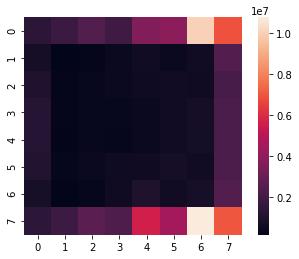

In [9]:
%%time
num_cm = round(sum(sum(reshaped_checkmates))/1000000,1)
print( f"The most common square for a king to be checkmated on, from {num_cm} million games" )
heatmap = sns.heatmap(reshaped_checkmates, square=True)
heatmap = heatmap.get_figure()
heatmap.savefig("heatmap-check")

The most common square for a king to end up on in a draw, from 301.3 million games
CPU times: user 99.9 ms, sys: 7.85 ms, total: 108 ms
Wall time: 116 ms


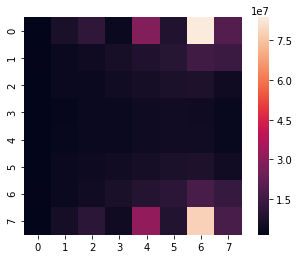

In [10]:
%%time
num_sm = round(sum(sum(reshaped_stalemates))/1000000,1)
print( f"The most common square for a king to end up on in a draw, from {num_sm/2} million games" )
heatmap = sns.heatmap(reshaped_stalemates, square=True)
heatmap = heatmap.get_figure()
heatmap.savefig("heatmap-stale")

In [34]:
#Started out with 10 billion lines in text files, representing 450 million games of chess (400 GB)
#Trimmed this down one line per game, i.e., 450 million lines (1.5 GB)
#Pivoted these 400m lines to fewer than 1 MB (just 224 bytes).
#And that's how you go from 400GB down to 224 bytes, half a billion games down to 4 heatmaps.
sys.getsizeof(reshaped_checkmates) + sys.getsizeof(reshaped_stalemates)

224